In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean
from datetime import datetime, timedelta, timezone
import urllib
import os.path
import string

%matplotlib inline

In [2]:
# Load survey times
survey_time = pd.read_csv("/Users/lachlanphillips/Development/PhD/repos/Eudyptula/data/transects/survey_times.csv")
survey_time['start_UTC'] = [datetime.strptime(dt, "%Y-%m-%d %H:%M:%S") for dt in survey_time['start_UTC']]
survey_time['end_UTC'] = [datetime.strptime(dt, "%Y-%m-%d %H:%M:%S") for dt in survey_time['end_UTC']]
# Create local survey times for displaying on plots
survey_time['start_AEST'] = [dt.replace(tzinfo=timezone.utc).astimezone(tz="UTC+10:00").date().strftime("%Y-%m-%d") for dt in survey_time['start_UTC']]
survey_time['end_AEST'] = [(dt.replace(tzinfo=timezone.utc).astimezone(tz="UTC+10:00").date() + timedelta(days=9)).strftime("%Y-%m-%d") for dt in survey_time['start_UTC']]
survey_time

,id,year,start_UTC,end_UTC,start_AEST,end_AEST
0,2015_S1,2015,2015-09-30 20:35:42,2015-10-07 22:29:08,2015-10-01,2015-10-10
1,2016_S1,2016,2016-09-15 22:00:37,2016-09-28 03:22:35,2016-09-16,2016-09-25
2,2016_S2,2016,2016-10-22 03:09:45,2016-11-02 02:27:31,2016-10-22,2016-10-31
3,2017_S1,2017,2017-08-14 22:34:51,2017-08-26 04:17:06,2017-08-15,2017-08-24
4,2017_S2,2017,2017-10-02 22:24:52,2017-10-13 05:04:28,2017-10-03,2017-10-12
5,2018_S1,2018,2018-08-22 22:38:58,2018-09-04 04:42:08,2018-08-23,2018-09-01
6,2018_S2,2018,2018-09-27 21:54:38,2018-10-01 02:33:09,2018-09-28,2018-10-07
7,2019_S1,2019,2019-09-24 01:26:33,2019-09-26 02:22:16,2019-09-24,2019-10-03
8,2019_S2,2019,2019-09-30 21:36:31,2019-10-02 05:57:46,2019-10-01,2019-10-10


In [3]:
# download data for each day of surveys (only do this once to avoid data consumption)
if False:
    for i, row in survey_time.iterrows():
        # make time series
        dates = pd.date_range(row.start_UTC - timedelta(days=7), row.end_UTC + timedelta(days=11))
        
        # download
        for d in dates:
            # SST
            download_url = "https://thredds.aodn.org.au/thredds/fileServer/IMOS/SRS/SST/ghrsst/L3S-1d/day/"+d.strftime("%Y")+"/"+d.strftime("%Y%m%d")+"032000-ABOM-L3S_GHRSST-SSTskin-AVHRR_D-1d_day.nc"
            fname = "/Volumes/LP_MstrData/master-data/ocean/IMOS/SST/SST_"+d.strftime("%Y%m%d")+".nc"
            if not os.path.isfile(fname):
                print("Downloading: "+download_url)
                urllib.request.urlretrieve(download_url, fname)
            else:
                print("Already downloaded: "+download_url)
            # ALT can be downloaded manually

# Load data for plot testing
if False:
    for i, row in survey_time.iterrows():
        # make time series
        dates = pd.date_range(row.start_UTC, row.end_UTC + timedelta(days=1))

        for d in dates:
                # load SST data
                sst = xr.open_dataset("/Volumes/LP_MstrData/master-data/ocean/IMOS/SST/SST_"+d.strftime("%Y%m%d")+".nc")
                # convert from Kelvin
                sst["sst"] = sst.sea_surface_temperature - 273.15

                # Load altimtry (unless already loaded)
                alt_fn = "/Volumes/LP_MstrData/master-data/ocean/IMOS/ALT/IMOS_OceanCurrent_HV_DM01_"+d.strftime("%Y")+".nc"
                alt = xr.open_dataset(alt_fn)

                # Make the plot
                print("loaded "+d.strftime("%Y-%m-%d"))
                
                break

        break



Loading 2015_S1
	Loading SST data..
	Loading ALT data..
	Calculating means..
	Loading SSTAARS climatology..
	Subsetting SST and calculating anomalies..
Plotting 2015_S1
Saving image "./figures/SST_ALT/composites/composite_2015_S1.png"

Loading 2016_S1
	Loading SST data..
	Loading ALT data..
	Calculating means..
	Loading SSTAARS climatology..
	Subsetting SST and calculating anomalies..
Plotting 2016_S1
Saving image "./figures/SST_ALT/composites/composite_2016_S1.png"

Loading 2016_S2
	Loading SST data..
	Loading ALT data..
	Calculating means..
	Loading SSTAARS climatology..
	Subsetting SST and calculating anomalies..
Plotting 2016_S2
Saving image "./figures/SST_ALT/composites/composite_2016_S2.png"

Loading 2017_S1
	Loading SST data..
	Loading ALT data..
	Calculating means..
	Loading SSTAARS climatology..
	Subsetting SST and calculating anomalies..
Plotting 2017_S1
Saving image "./figures/SST_ALT/composites/composite_2017_S1.png"

Loading 2017_S2
	Loading SST data..
	Loading ALT data..

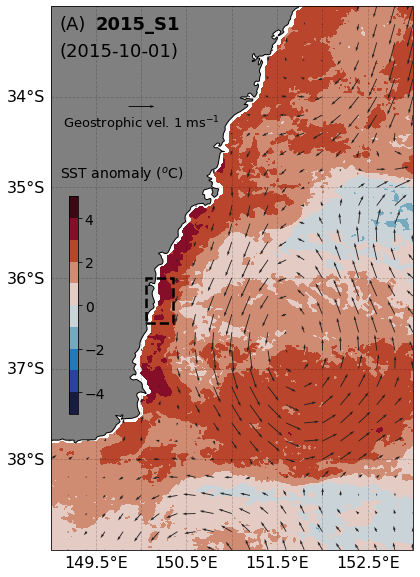

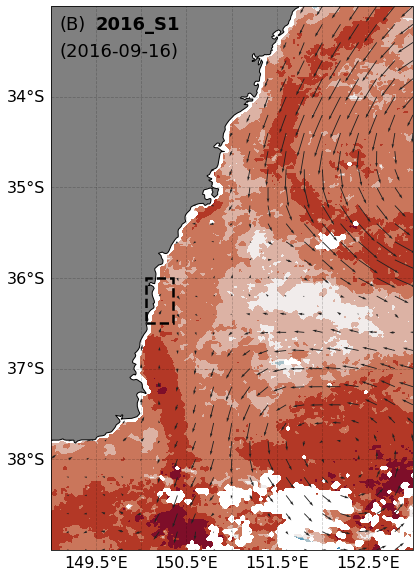

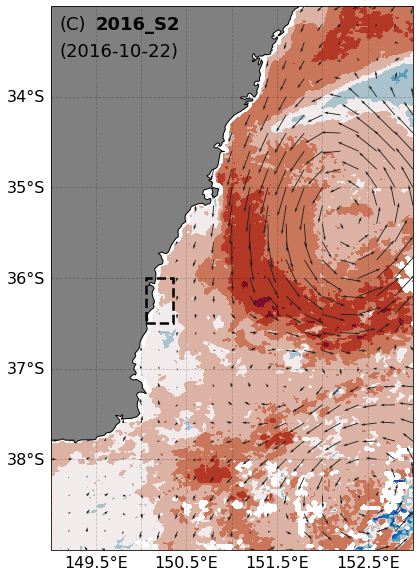

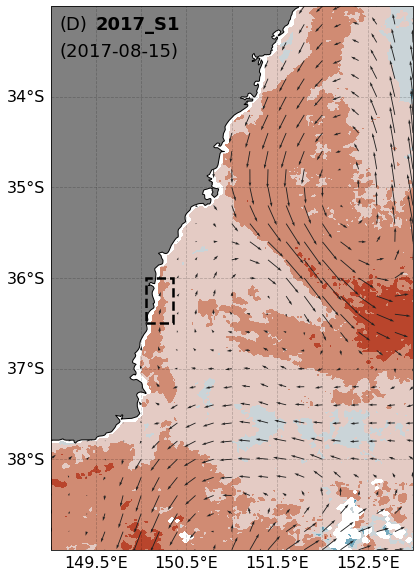

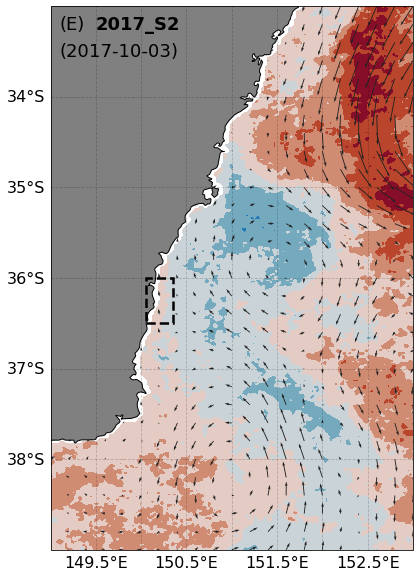

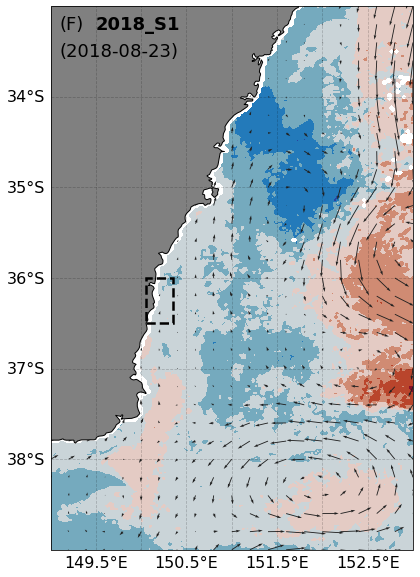

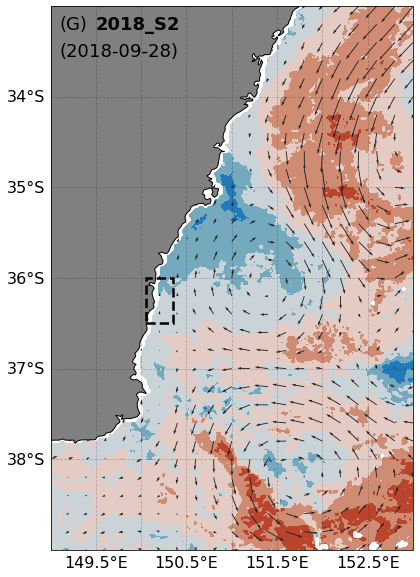

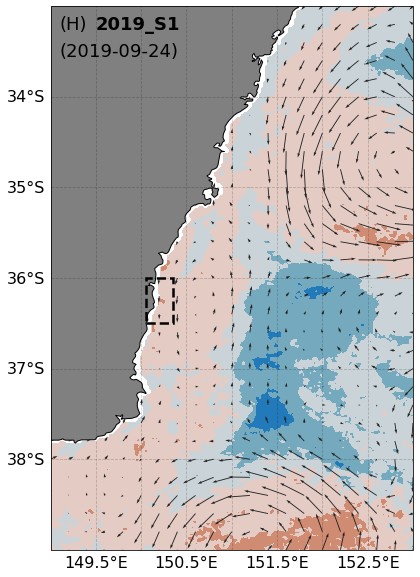

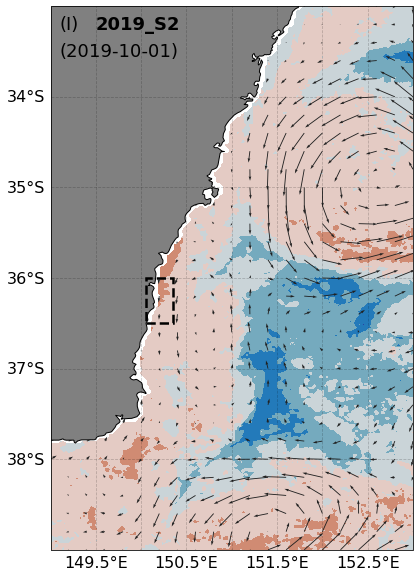

In [15]:
#### Composite images
# Read in SSTAARS dataset
stars = xr.open_dataset("data/IMOS/SSTAARS/IMOS_aggregation_20220609T000908Z/IMOS_aggregation_20220609T000908Z.nc",  decode_times=False)

# Process each day in the survey time and merge together by mean
for i, row in survey_time.iterrows():
    print("\nLoading "+row.id)
    # make time series
    dates = pd.date_range(row.start_UTC, row.start_UTC + timedelta(days=9))
    
    #__Load SST__
    print("\tLoading SST data..")
    sst_ls = [xr.open_dataset("/Volumes/LP_MstrData/master-data/ocean/IMOS/SST/SST_"+d.strftime("%Y%m%d")+".nc") for d in dates]
    # Filter to keep only var of interest (speed things up)
    sst_ls = [sst[['sea_surface_temperature', 'quality_level']] for sst in sst_ls]
    sst = xr.concat(sst_ls, dim="time")
    sst["sst"] = sst.sea_surface_temperature - 273.15
    # Get day  of year
    DoY = [pd.Timestamp(t).timetuple().tm_yday for t in np.asarray(sst.time)]
    
    #__Load ALT__
    print("\tLoading ALT data..")
    alt_fn = "/Volumes/LP_MstrData/master-data/ocean/IMOS/ALT/IMOS_OceanCurrent_HV_DM01_"+dates[0].strftime("%Y")+".nc"
    alt = xr.open_dataset(alt_fn)
    # subset by time
    alt = alt.sel(TIME=slice(dates[0] - timedelta(days=1), dates[-1]))
    # Filter to keep only vars of interest (speed things up)
    alt = alt[["UCUR", "VCUR"]]
    
    # take mean over time
    print("\tCalculating means..")
    sst = sst.mean(dim="time")
    alt = alt.mean(dim="TIME")
    
    #__Load in SSTAARS climatology__
    print("\tLoading SSTAARS climatology..")
    # Reduce to time period
    stars_data = stars.sel(DAY_OF_YEAR=DoY)
    # Take mean over time
    stars_data = stars_data.mean(dim="DAY_OF_YEAR")
    
    #__Resize SST and calculate anomaly__
    print("\tSubsetting SST and calculating anomalies..")
    sst_interp = sst.interp(lat=stars_data.LATITUDE, lon=stars_data.LONGITUDE)
    sst_anom = sst_interp['sst'] - stars_data['TEMP']
    
    # __PLOT__
    print("Plotting "+row.id)
    fig = plt.figure(figsize=(18,10))
    ax = plt.subplot(1,1,1,projection=ccrs.PlateCarree())

    #set coastline
    coast = cfeature.NaturalEarthFeature(category='physical', scale='10m', 
                                         facecolor='none', name='coastline')
    feature = ax.add_feature(coast, edgecolor='black',facecolor='gray')
    im = sst_anom.plot.contourf(cmap=cmocean.cm.balance, add_colorbar=False,
                                vmin=-5, vmax=5, levels=11)
    Q = plt.quiver(alt.LONGITUDE, alt.LATITUDE, alt.UCUR,
                   alt.VCUR, units='width', scale=14, color="#212121")
    extent_ls = [149,153,-33,-39]
    ax.set_extent(extent_ls)

    # make pretty gridlines and labels
    gl = ax.gridlines(draw_labels=True, color='black',
                      alpha=0.2, linestyle='--')
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    gl.xlabel_style = {'size': 16}
    gl.ylabel_style = {'size': 16}

    # labels
    # Lab
    plt.text(extent_ls[0]+.1, extent_ls[2]-.25,
             "("+string.ascii_uppercase[i]+")", size=18)
    # ID
    plt.text(extent_ls[0]+.5, extent_ls[2]-.251,
             row.id, weight='bold', size=18)
    # Time range
    plt.text(extent_ls[0]+.1, extent_ls[2]-.55,
             "("+row.start_AEST+")", size=18)
    # SST lab
    if row.id == "2015_S1":
        plt.text(extent_ls[0]+.1, extent_ls[2]-1.9,
                 'SST anomaly ($^o$C)', size=14)
    
    # Geostrophic key (first plot only)
    if row.id == "2015_S1":
        plt.quiverkey(Q, X=extent_ls[0]+1.0, Y=extent_ls[2]-1.10, U=1,
                      color='black', coordinates='data',
                      label='Geostrophic vel. 1 ms$^{-1}$', labelpos='S',
                      fontproperties={"size":13})
    
    plt.title(None)

    # add survey area
    ax.add_patch(mpatches.Rectangle(xy=[150.05, -36.5], width=.3, height=.5, linestyle="--",
                                    linewidth=2.5, zorder=10,
                                    edgecolor='black', fill=False,
                                    alpha=1.0,
                                    transform=ccrs.PlateCarree()))

    # colorbar (for first plot)
    if row.id == "2015_S1":
        cax = inset_axes(ax,
                         width="2.5%",  # % of parent_bbox width
                         height="40%",
                         loc='lower left',
                         bbox_to_anchor=(.05,.25, 1, 1), #(.05,.39, 1, 1) 51 to 71
                         bbox_transform=ax.transAxes,
                         borderpad=0)
        fig.colorbar(im, cax=cax)
        cax.tick_params(labelsize=14) 
    
    # Save fig
    print('Saving image "./figures/SST_ALT/composites/composite_'+row.id+'.png"')
    plt.savefig("./figures/SST-anom_ALT/composites/composite_"+row.id+".png",
                        format="png",
                        bbox_inches='tight',
                        pad_inches=0.1, 
                        dpi=300)
    
    #break
